# Tutorial for the montecarlo python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

## Loading and using the package

To load, make sure you are in the top directory and do

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import model

# For Jupyter notebooks only:
%matplotlib inline

## Run photon packets in parallel plane medium

This is an example code to run a Monte Carlo calculation for photon packets travelling in a scattering medium.

Set random number seed.  This is so that the code produces the same trajectories each time (for testing purposes).  Comment this out or set the seed to `None` for real calculations.

In [2]:
seed = 1

In [3]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity('0.125 um')
volume_fraction = sc.Quantity(0.5, '')
n_particle = sc.Quantity(1.54, '')      # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelen)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelen)      # space within sample. n_medium is outside the sample. 
                                        # n_particle can have a complex refractive index if absorption is desired
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction, absorption=False) # set to True if n_particle is complex
                                                                             # and presence of absorption is desired

In [4]:
#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  phase_mie=False, mu_scat_mie=False)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

## Plot trajectories

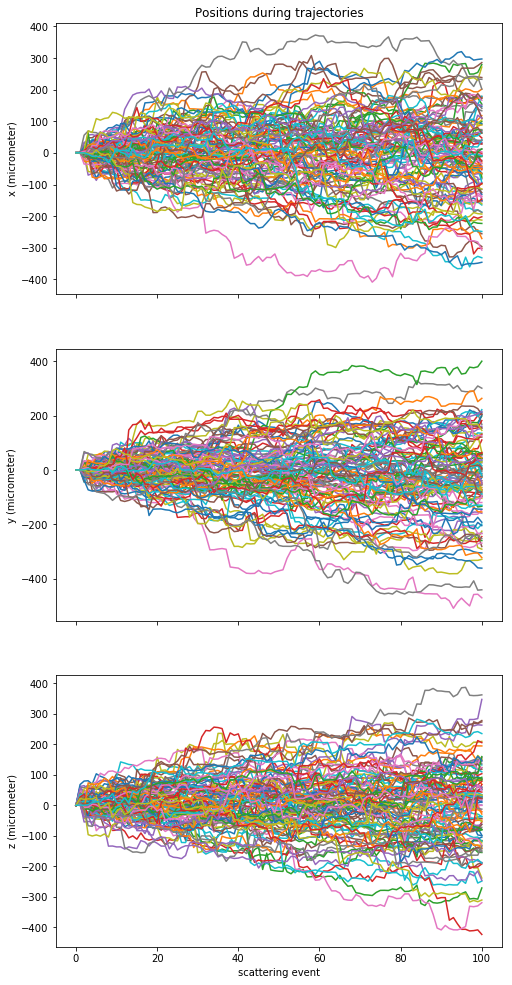

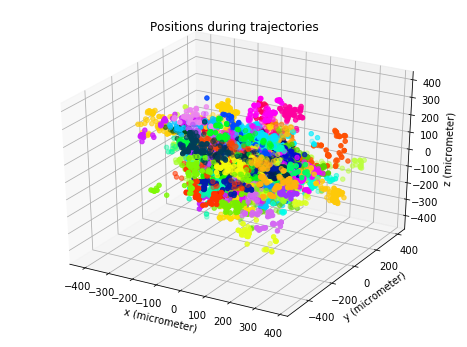

In [5]:
trajectories.plot_coord(ntrajectories, three_dim=True)

## Calculate the fraction of trajectories that are reflected and transmitted

In [6]:
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

R_fraction, T_fraction = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs))

R = 0.701378758963
T = 0.298621241037
Absorption coefficient = 0.0 / micrometer


## Add an absorber to the system

In [7]:
# Choose some absorption coefficient corresponding to some absorber
mu_abs_dye = sc.Quantity(0.01,'1/um')

# Create new trajectories object
trajectories_dye = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories_dye.absorb(mu_abs_dye, step)                         
trajectories_dye.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories_dye.move(step)
R_fraction, T_fraction = mc.calc_refl_trans(trajectories_dye, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))
print('Absorption coefficient = ' + str(mu_abs_dye))

R = 0.361345703236
T = 0.0969235043193
Absorption coefficient = 0.01 / micrometer


The reflected fraction decreases with the addition of an absorber as expected. 

## Calculate reflection fraction for a system of core-shell particles

When the system is made of core-shell particles, we must specify the refractive index, radius, and volume fraction  of each layer, from innermost to outermost. 

In [8]:
# Properties of system
ntrajectories = 100                     # number of trajectories
nevents = 100                           # number of scattering events in each trajectory
wavelen = sc.Quantity('600 nm')
radius = sc.Quantity(np.array([0.125, 0.13]), 'um')  # specify the radii from innermost to outermost layer
n_particle = sc.Quantity(np.array([1.54,1.33]), '')  # specify the index from innermost to outermost layer           
n_matrix = ri.n('vacuum', wavelen)      
n_medium = ri.n('vacuum', wavelen)     
volume_fraction = sc.Quantity(0.5, '')  # this is the volume fraction of the core-shell particle as a whole

# Calculate the volume fractions of each layer
vf_array = np.empty(len(radius))
r_array = np.array([0] + radius.magnitude.tolist()) 
for r in np.arange(len(r_array)-1):
    vf_array[r] = (r_array[r+1]**3-r_array[r]**3) / (r_array[-1:]**3) * volume_fraction.magnitude

n_sample = ri.n_eff(n_particle, n_matrix, vf_array, absorption=False) 

In [9]:
#%%timeit
# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(radius, n_particle, n_sample, volume_fraction, wavelen, 
                                  phase_mie=False, mu_scat_mie=False)

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, seed=seed, incidence_angle = 0.)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
    
# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

# Calculate the reflection and transmission fractions
z_low = sc.Quantity('0.0 um')
cutoff = sc.Quantity('50 um')

R_fraction, T_fraction = mc.calc_refl_trans(trajectories, z_low, cutoff, n_medium, n_sample)

print('R = '+ str(R_fraction))
print('T = '+ str(T_fraction))

R = 0.769986057833
T = 0.230013942167
